In [1]:
import sys
import os
import json
import torch
import random
import numpy as np
from tqdm.auto import tqdm
from PIL import Image
import re
from transformers import LlavaOnevisionForConditionalGeneration, AutoProcessor
from datasets import load_dataset, concatenate_datasets
from typing import Optional, Tuple
from torch import nn
import matplotlib.pyplot as plt
torch.set_grad_enabled(False)
import seaborn as sns
from types import MethodType
# os.chdir("/home/jacksonmicha_umass_edu/multimodal-modality-conflict")

In [10]:
def load_noop(data_path, subject, split="validation", noop_root="/jet/home/billyli/mmmu_NoOps/mmmu-noop", noOps='text'):
    from datasets import load_dataset
    # Load your dataset
    ds = load_dataset(data_path, subject, split=split)
    
    if noOps == "text" or noOps == "all":
        # Load the NoOp data from JSON
        noop_file = os.path.join(noop_root, f"mmmu_{split}_noop_insert_sentence.json")
        with open(noop_file, 'r') as f:
            noop_data = json.load(f)
        
    if noOps == "img" or noOps == "all":
        # Load the NoOp data from JSON
        img_noop_file = os.path.join(noop_root, f"val_img_NoOp_metadata.json")
        with open(img_noop_file, 'r') as f:
            img_data = json.load(f)
    
    # Define a function that adds "noop" to each example
    def add_noop(example, noOps, noOp_root="/jet/home/billyli/data_folder/NoOpImgs/mmmu_NoOp_imgs"):
        example_id = example['id']
        if noOps == "text" or noOps == "all":
            # print("adding text noop")
            example['noop'] = noop_data.get(example_id, None)  # fallback if ID not found
        if noOps == "img" or noOps == "all":
            example['noop_imgs'] = True
            img_datum = img_data[example_id]['image_paths']
            image_names = [f"image_{n}" for n in range(1, 8)]
            imgs = [(name, example[name]) for name in image_names if example[name] is not None]
            for img_pair, imgNoOp in zip(imgs, img_datum):
                name, img = img_pair
                noOp_path = os.path.join(noOp_root, example_id, name + ".png") 
                # example[name] = Image.open(imgNoOp + ".png")
                example[name] = Image.open(noOp_path)
                # print("adding img noop: ", name)
        return example

    # Use .map() to apply the function and return a new dataset with the `noop` column
    ds = ds.map(lambda x: add_noop(x, noOps))

    return ds

def prepare_NoOp(data_path, split, all_subs, noOps='text'):
    print(f"Loading MMMU dataset from {data_path} for split={split} ...")
    sub_dataset_list = [load_noop(data_path, subject, split=split, noOps=noOps) for subject in tqdm(all_subs)]
    dataset = concatenate_datasets(sub_dataset_list)
    print("NoOp Dataset loaded:", dataset)
    return dataset

def prepare_dataset(data_path, split, all_subs):
    print(f"Loading MMMU dataset from {data_path} for split={split} ...")
    sub_dataset_list = [load_dataset(data_path, subject, split=split) for subject in tqdm(all_subs)]
    dataset = concatenate_datasets(sub_dataset_list)
    print("Dataset loaded:", dataset)
    return dataset

In [11]:
all_subs = [
    'Accounting', 'Agriculture', 'Architecture_and_Engineering', 'Art',
    'Art_Theory','Basic_Medical_Science','Biology','Chemistry','Clinical_Medicine',
    'Computer_Science','Design','Diagnostics_and_Laboratory_Medicine','Economics',
    'Electronics','Energy_and_Power','Finance','Geography','History','Literature',
    'Manage','Marketing','Materials','Math','Mechanical_Engineering','Music',
    'Pharmacy','Physics','Psychology','Public_Health','Sociology'
]
noop = "all"
data_path = "MMMU/MMMU"
split = "validation"
subs = ['Accounting', 'Agriculture', 'Music']
if noop != "none":
    dataset = prepare_NoOp(data_path, split, subs, noop)
else:
    dataset = prepare_dataset(data_path, split, subs)

Loading MMMU dataset from MMMU/MMMU for split=validation ...


  0%|          | 0/3 [00:00<?, ?it/s]

Map:   0%|          | 0/30 [00:00<?, ? examples/s]

Map:   0%|          | 0/30 [00:00<?, ? examples/s]

Map:   0%|          | 0/30 [00:00<?, ? examples/s]

NoOp Dataset loaded: Dataset({
    features: ['id', 'question', 'options', 'explanation', 'image_1', 'image_2', 'image_3', 'image_4', 'image_5', 'image_6', 'image_7', 'img_type', 'answer', 'topic_difficulty', 'question_type', 'subfield', 'noop', 'noop_imgs'],
    num_rows: 90
})


In [12]:
model_id = "llava-hf/llava-onevision-qwen2-0.5b-ov-hf"
device = "cuda:0"
model = LlavaOnevisionForConditionalGeneration.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    trust_remote_code=True,
).to(device)
processor = AutoProcessor.from_pretrained(
    model_id,
    trust_remote_code=True
)

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [13]:
def test_vision_attn(image):
    instruct = "you are an advanced question answer model, please answer this question to the best of your ability with a single letter in brackets like this [X]."
    question_text = "Who created <image 1>?"
    answers = 'A: ARKHIP KUINII B: PAUL SIGNAC C: GEORGES SEURAT D: VALENTIN SEROV'
    
    content = [
        {"type": "text", "text": instruct},
        {"type": "image"},
        {"type": "text", "text": question_text},
        {"type": "text", "text": answers},
    ]
    response = {"role": "user", "content": content}
    prompt = processor.apply_chat_template([response], add_generation_prompt=True)
    inputs = processor(
        text=[prompt],
        images=[image],
        return_tensors="pt",
        padding=True
    )
    for k in inputs:
        inputs[k] = inputs[k].to(device)
    
    generation_config = {
        "max_new_tokens": 32,
        "temperature": 1.0,
        "do_sample": False,
        "num_beams": 1,
        "repetition_penalty": 1.0,
        "length_penalty": 1.0,
        "early_stopping": True,
        "pad_token_id": processor.tokenizer.eos_token_id,
        "return_dict_in_generate": True,
        "output_attentions": True
    }

    with torch.no_grad():
        output = model(
            **inputs, output_attentions=True
        )
        return output

{'id': 'validation_Accounting_11', 'question': 'Donna Donie, CFA, has a client who believes the common stock price of TRT Materials (currently $58 per share) could move substantially in either direction in reaction to an expected court decision involving the company. The client currently owns no TRT shares, but asks Donie for advice about implementing a strangle strategy to capitalize on the possible stock price movement. A strangle is a portfolio of a put and a call with different exercise prices but the same expiration date. Donie gathers the TRT option-pricing data: <image 1> Calculate, at expiration for long strangle strategy, the Maximum possible loss per share.', 'options': "['$9.00', '$5.00', 'the Maximum  possible loss is unlimited']", 'explanation': '', 'image_1': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=823x230 at 0x152DACDBAEE0>, 'image_2': None, 'image_3': None, 'image_4': None, 'image_5': None, 'image_6': None, 'image_7': None, 'img_type': "['Tables']", 'answe

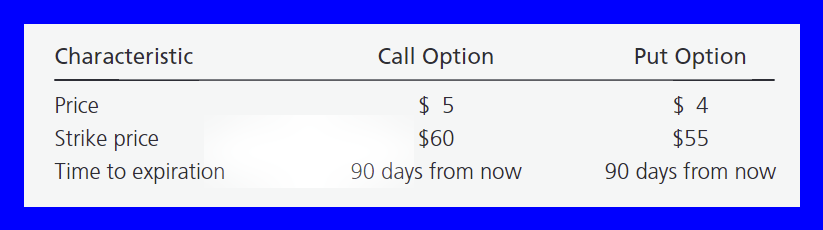

In [17]:
img = dataset[10]['image_1']
# valid, output, inputs = test_vision_attn(img)
output = test_vision_attn(img)
print(dataset[10])
img

In [18]:
idx = output.logits[0, -1].argmax()
token = processor.batch_decode([idx])
token

['B']